<a href="https://colab.research.google.com/github/kursataker/cng562-machine-learning-spring-19/blob/master/1D_CNN_HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Activity Recognition

**Ref:** https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

## Data Set Information

The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data. 

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.

## Attribute Information

For each record in the dataset it is provided: 
- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 
- An identifier of the subject who carried out the experiment.

## Download Human Activity Recognition Data

Ref: https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

In [0]:
!pip install wget

  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import wget
wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip')

'UCI HAR Dataset.zip'

In [0]:
!ls -al UCI*

-rw-r--r-- 1 root root 60999314 May  6 11:01 'UCI HAR Dataset.zip'


In [0]:
!unzip 'UCI HAR Dataset.zip'

Archive:  UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating: UCI HAR

In [0]:
!ls -al 'UCI HAR Dataset'

total 56
drwxr-xr-x 4 root root  4096 Feb 16  2015 .
drwxr-xr-x 1 root root  4096 May  6 11:01 ..
-rwxr-xr-x 1 root root    80 Oct 10  2012 activity_labels.txt
-rw-r--r-- 1 root root  6148 Feb 16  2015 .DS_Store
-rwxr-xr-x 1 root root  2809 Oct 15  2012 features_info.txt
-rwxr-xr-x 1 root root 15785 Oct 11  2012 features.txt
-rw-r----- 1 root root  6304 Feb 16  2015 README.txt
drwxr-xr-x 3 root root  4096 Nov 30  2012 test
drwxr-xr-x 3 root root  4096 Nov 30  2012 train


In [0]:
! mv 'UCI HAR Dataset' HARDataset

In [0]:
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

In [0]:


# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 
                'total_acc_y_'+group+'.txt', 
                'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 
                'body_acc_y_'+group+'.txt', 
                'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 
                'body_gyro_y_'+group+'.txt', 
                'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy


In [0]:

# fit and evaluate a model
def evaluate_model1(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 10, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                   input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(Dropout(0.5))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy



# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(evaluate_model=evaluate_model1, repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)



In [0]:
# run the experiment
run_experiment()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
>#1: 90.702
>#2: 90.838
>#3: 88.327
>#4: 88.972
>#5: 91.110
>#6: 90.567
>#7: 91.313
>#8: 90.567
>#9: 86.359
>#10: 91.415
[90.70240922972515, 90.83814048184594, 88.32711231761114, 88.97183576518493, 91.10960298608755, 90.56667797760434, 91.31319986426874, 90.56667797760434, 86.35900916185952, 91.41499830335935]
Accuracy: 90.017% (+/-1.546)


(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
(470528, 9)


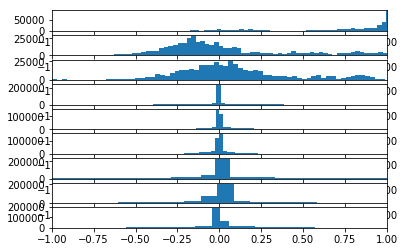

In [0]:
# plot a histogram of each variable in the dataset
def plot_variable_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()
 
# load data
trainX, trainy, testX, testy = load_dataset()
# plot histograms
plot_variable_distributions(trainX)

In [0]:
from sklearn.preprocessing import StandardScaler

# standardize data
def scale_data(trainX, testX, standardize):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	# flatten train and test
	flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
	flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
	# standardize
	if standardize:
		s = StandardScaler()
		# fit on training data
		s.fit(longX)
		# apply to training and test data
		longX = s.transform(longX)
		flatTrainX = s.transform(flatTrainX)
		flatTestX = s.transform(flatTestX)
	# reshape
	flatTrainX = flatTrainX.reshape((trainX.shape))
	flatTestX = flatTestX.reshape((testX.shape))
	return flatTrainX, flatTestX

In [0]:
def evaluate_model2(trainX, trainy, testX, testy, param):
	verbose, epochs, batch_size = 0, 10, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	# scale data
	trainX, testX = scale_data(trainX, testX, param)
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(Dropout(0.5))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

In [0]:
# run an experiment
def run_experiment2(params, evaluate_model=evaluate_model2, repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# test each parameter
	all_scores = list()
	for p in params:
		# repeat experiment
		scores = list()
		for r in range(repeats):
			score = evaluate_model(trainX, trainy, testX, testy, p)
			score = score * 100.0
			print('>p=%d #%d: %.3f' % (p, r+1, score))
			scores.append(score)
		all_scores.append(scores)
	# summarize results
	summarize_results(all_scores, params)

In [0]:
# summarize scores
def summarize_results(scores, params):
	print(scores, params)
	# summarize mean and standard deviation
	for i in range(len(scores)):
		m, s = mean(scores[i]), std(scores[i])
		print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
	# boxplot of scores
	pyplot.boxplot(scores, labels=params)
	pyplot.savefig('exp_cnn_standardize.png')

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>p=0 #1: 88.972
>p=0 #2: 92.297
>p=0 #3: 91.992
>p=0 #4: 90.940
>p=0 #5: 88.700
>p=0 #6: 93.315
>p=0 #7: 90.940
>p=0 #8: 90.363
>p=0 #9: 92.229
>p=0 #10: 89.040
>p=1 #1: 91.788
>p=1 #2: 90.906
>p=1 #3: 93.044
>p=1 #4: 90.567
>p=1 #5: 90.974
>p=1 #6: 90.193
>p=1 #7: 90.635
>p=1 #8: 90.499
>p=1 #9: 90.193
>p=1 #10: 91.177
[[88.97183576518493, 92.29725144214456, 91.99185612487275, 90.93993892093654, 88.70037326094334, 93.31523583305056, 90.93993892093654, 90.36308109942314, 92.22938581608415, 89.03970139124533], [91.78825924669155, 90.90600610790635, 93.04377332880895, 90.56667797760434, 90.97387173396675, 90.19341703427214, 90.63454360366474, 90.49881235154395, 90.19341703427214, 91.17746861214795]] [False, True]
Param=0: 90.879% (+/-1.518)
Param=1: 90.998% (+/-0.819)


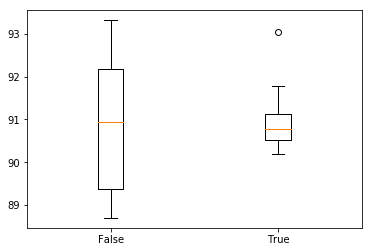

In [0]:
# run the experiment
n_params = [False, True]
run_experiment2(n_params)

In [0]:
def evaluate_model3(trainX, trainy, testX, testy, param):
  verbose, epochs, batch_size = 0, 10, 32
  n_timesteps, n_features, n_outputs = (
      trainX.shape[1], trainX.shape[2], trainy.shape[1] 
  )
  trainX, testX = scale_data(trainX, testX, param)
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                   input_shape=(n_timesteps, n_features)))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics=['accuracy'])
  model.fit(trainX, trainy, 
            epochs=epochs, batch_size=batch_size, verbose=verbose)
  _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  return accuracy

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>p=0 #1: 83.950
>p=0 #2: 91.924
>p=0 #3: 90.872
>p=0 #4: 90.159
>p=0 #5: 90.702
>p=0 #6: 91.890
>p=0 #7: 88.056
>p=0 #8: 91.177
>p=0 #9: 90.702
>p=0 #10: 88.361
>p=1 #1: 90.668
>p=1 #2: 90.227
>p=1 #3: 92.060
>p=1 #4: 90.126
>p=1 #5: 92.399
>p=1 #6: 92.467
>p=1 #7: 93.281
>p=1 #8: 89.617
>p=1 #9: 92.365
>p=1 #10: 91.958
[[83.9497794367153, 91.92399049881234, 90.87207329487615, 90.15948422124194, 90.70240922972515, 91.89005768578215, 88.05564981336953, 91.17746861214795, 90.70240922972515, 88.36104513064133], [90.66847641669494, 90.22734984730234, 92.05972175093315, 90.12555140821175, 92.39904988123516, 92.46691550729555, 93.28130302002036, 89.61655921275874, 92.36511706820495, 91.95792331184255]] [False, True]
Param=0: 89.779% (+/-2.303)
Param=1: 91.517% (+/-1.180)


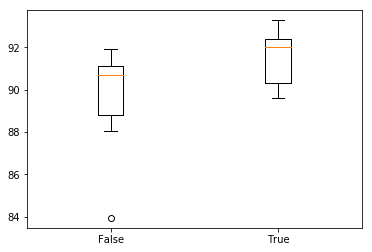

In [0]:
# run the experiment
n_params = [False, True]
run_experiment2(n_params, evaluate_model=evaluate_model3)

In [0]:
def evaluate_model4(trainX, trainy, testX, testy, param):
  verbose, epochs, batch_size = 0, 10, 32
  n_timesteps, n_features, n_outputs = (
      trainX.shape[1], trainX.shape[2], trainy.shape[1] 
  )
  trainX, testX = scale_data(trainX, testX, param)
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                   input_shape=(n_timesteps, n_features)))
  model.add(BatchNormalization())
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics=['accuracy'])
  model.fit(trainX, trainy, 
            epochs=epochs, batch_size=batch_size, verbose=verbose)
  _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  return accuracy

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>p=0 #1: 89.617
>p=0 #2: 91.585
>p=0 #3: 92.331
>p=0 #4: 90.227
>p=0 #5: 89.243
>p=0 #6: 90.329
>p=0 #7: 89.956
>p=0 #8: 89.447
>p=0 #9: 91.483
>p=0 #10: 90.295
>p=1 #1: 93.417
>p=1 #2: 91.788
>p=1 #3: 88.633
>p=1 #4: 92.297
>p=1 #5: 89.650
>p=1 #6: 91.551
>p=1 #7: 92.060
>p=1 #8: 90.397
>p=1 #9: 88.497
>p=1 #10: 90.974
[[89.61655921275874, 91.58466236851035, 92.33118425517476, 90.22734984730234, 89.24329826942655, 90.32914828639295, 89.95588734306074, 89.44689514760775, 91.48286392941975, 90.29521547336275], [93.41703427214117, 91.78825924669155, 88.63250763488293, 92.29725144214456, 89.65049202578894, 91.55072955548015, 92.05972175093315, 90.39701391245333, 88.49677638276214, 90.97387173396675]] [False, True]
Param=0: 90.451% (+/-0.969)
Param=1: 90.926% (+/-1.535)


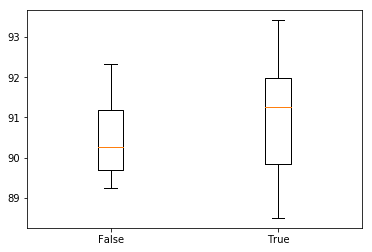

In [0]:
# run the experiment
n_params = [False, True]
run_experiment2(n_params, evaluate_model=evaluate_model4)